In [1]:
from __future__ import division
%matplotlib inline

In [2]:
import qinfer as qi

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
try:
    plt.style.use('ggplot')
except:
    pass

Let's start by making some fake data from a precession experiment (e.g.: Rabi, Ramsey or phase estimation).

In [5]:
true_omega = 70.3
omega_min, omega_max = [10.3, 99.1]
n_shots = 400

ts = np.pi * (1 + np.arange(100)) / (2 * omega_max)

signal = np.sin(true_omega * ts / 2) ** 2
counts = np.random.binomial(n=n_shots, p=signal)

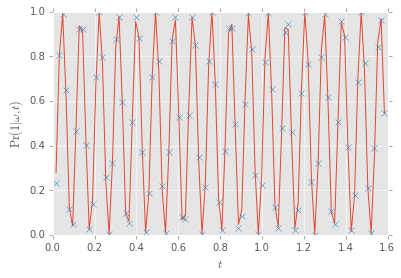

In [6]:
plt.plot(ts, signal)
plt.plot(ts, counts / n_shots, 'x')
plt.xlabel('$t$')
plt.ylabel(r'$\Pr(1 | \omega, t)$')

In [7]:
data = np.column_stack([counts, ts, n_shots * np.ones_like(counts)])

In [8]:
with qi.timing() as timing:
    mean, cov, extra = qi.simple_est_prec(data, freq_min=omega_min, freq_max=omega_max, return_all=True)
print("{:0.3}s elapsed.".format(timing.delta_t))

0.259s elapsed.


(0.0, 90.0)

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


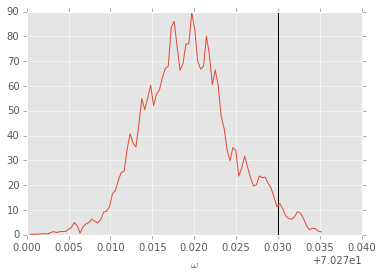

In [9]:
extra['updater'].plot_posterior_marginal()
ylim = plt.ylim()
plt.vlines(true_omega, *ylim)
plt.ylim(*ylim)